In this notebook, Adaboost hyperparameters will be tuned on the final feature dataframe. Final model parameters will be chosen based on the one which gives best ROC AUC metric.
First Adaboost base model will be developed on SMOTE and non SMOTE data. Based on the model performance on these two, final hyperparameters will be tuned on either SMOTE or NON SMOTE data.

## Importing libraries, modules and data

In [ ]:
# Importing the required libraries and modules
import os
import zipfile
import numpy as np
import pandas as pd
from datetime import datetime
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,classification_report,confusion_matrix,roc_curve,auc,precision_recall_curve,roc_curve
from tqdm import tqdm
!pip install kds
import kds
from IPython.display import Image

In [ ]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Importing the train test oot and train_smote dataframes
pickle_path = '/content/drive/MyDrive/Career/DS/Case Studies/Home Credit Default Risk/'

#1. X_train dataframe
pickle_in=open(pickle_path+"X_train_final.pickle","rb")
X_train=pickle.load(pickle_in)
pickle_in.close()
print("Shape of X_train dataframe is",X_train.shape)

#2. y_train dataframe
pickle_in=open(pickle_path+"y_train_final.pickle","rb")
y_train=pickle.load(pickle_in)
pickle_in.close()
print("Shape of y_train dataframe is",y_train.shape)

#3. X_train_smote dataframe
pickle_in=open(pickle_path+"X_train_smote_final.pickle","rb")
X_train_smote=pickle.load(pickle_in)
pickle_in.close()
print("Shape of X_train_smote dataframe is",X_train_smote.shape)

#4. y_train_smote dataframe
pickle_in=open(pickle_path+"y_train_smote_final.pickle","rb")
y_train_smote=pickle.load(pickle_in)
pickle_in.close()
print("Shape of y_train_smote dataframe is",y_train_smote.shape)

#5. X_test dataframe
pickle_in=open(pickle_path+"X_test_final.pickle","rb")
X_test=pickle.load(pickle_in)
pickle_in.close()
print("Shape of X_test dataframe is",X_test.shape)

#6. y_test dataframe
pickle_in=open(pickle_path+"y_test_final.pickle","rb")
y_test=pickle.load(pickle_in)
pickle_in.close()
print("Shape of y_test dataframe is",y_test.shape)

#7. X_oot dataframe
pickle_in=open(pickle_path+"X_oot_final.pickle","rb")
X_oot=pickle.load(pickle_in)
pickle_in.close()
print("Shape of X_oot dataframe is",X_oot.shape)

#8. y_oot dataframe
pickle_in=open(pickle_path+"y_oot_final.pickle","rb")
y_oot=pickle.load(pickle_in)
pickle_in.close()
print("Shape of y_oot dataframe is",y_oot.shape)

#9. X_test_oot dataframe
pickle_in=open(pickle_path+"X_test_oot_final.pickle","rb")
X_test_oot=pickle.load(pickle_in)
pickle_in.close()
print("Shape of X_test_oot dataframe is",X_test_oot.shape)

Shape of X_train dataframe is (246008, 15)
Shape of y_train dataframe is (246008,)
Shape of X_train_smote dataframe is (452272, 15)
Shape of y_train_smote dataframe is (452272,)
Shape of X_test dataframe is (30751, 15)
Shape of y_test dataframe is (30751,)
Shape of X_oot dataframe is (30752, 15)
Shape of y_oot dataframe is (30752,)
Shape of X_test_oot dataframe is (48744, 15)


## Model Functions

In [ ]:
def PlotConfusionMatrix(y_test,pred_test):
  cf=metrics.confusion_matrix(y_test,pred_test)

  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ['{0:0.0f}'.format(value) for value in cf.flatten()]
  group_percentages = ['{0:0.2%}'.format(value) for value in cf.flatten()/np.sum(cf)]
  labels=[f'{v1}\n{v2}\n{v3}' for v1,v2,v3 in zip(group_names,group_counts,group_percentages)]
  labels=np.asarray(labels).reshape(2,2)

  fig=plt.figure(figsize=(15,5))
  ax=fig.add_subplot(1,2,1)
  sns.heatmap(cf,cmap='crest',linewidth=0.5,annot=labels,fmt='',ax=ax)
  plt.title('Confusion Matrix')
  plt.ylabel('Real Classes')
  plt.xlabel('Predicted Classes')
  plt.show()

  accuracy = np.trace(cf) / float(np. sum(cf))
  precision = cf[1,1] / sum(cf[:,1])
  recall = cf[1,1]/sum(cf[1,:])
  f1_score = 2*precision*recall / (precision + recall)

  stats_text = "Accuracy={:0.5f}\nPrecision={:0.5f}\nRecall={:0.5f}\nF1 Score={:0.5F}".format(accuracy,precision,recall,f1_score)
  print("----------------Classification Report----------------")
  print(classification_report(y_test,pred_test))
  print("\n",'----------------Accuracy, precision, recall, f1_score----------------')
  print(stats_text)


In [ ]:
def decile_tablel(act,prob,round_decimal=10,change_deciles=10):
  qq=kds.metrics.decile_table(act,prob
                              ,round_decimal=round_decimal
                              ,change_deciles=change_deciles
                              ,labels=False)[['decile',
                                              'prob_min', 'prob_max',
                                              'cnt_cust', 'cnt_resp',
                                              'cnt_non_resp','cum_non_resp',
                                              'cum_resp', 'KS', 'lift']]
  qq["FP"]=round(qq['cnt_non_resp']/qq['cnt_resp'],2)
  qq["FP_cumm"]=round(qq['cum_non_resp']/qq['cnt_resp'],2)
  qq['prob_min']= round(qq['prob_min'], 6)
  qq['frd_cptr%'] = round(qq['cum_resp']/qq.cnt_resp.sum()*100,2)
  qq.columns = ['decile', 'prob_min', 'prob_max', 'ttl_customers', 'bad_customers','gd_customers', 'cum gd_customers',
                'cum_bad_customers', 'KS', 'Lift', 'FP', 'cum FP', 'default_captr%']
  return qq

In [ ]:
def ROC_curve_combined(actl_train,pred_train,actl_test,pred_test,actl_oot,pred_oot):
  print('Ploting the ROC Curve')
  fpr_train, tpr_train, thresholds =metrics.roc_curve(actl_train, pred_train)
  roc_auc_train = metrics.auc(fpr_train, tpr_train)*100 # compute area under the curve

  fpr_test, tpr_test, thresholds =metrics.roc_curve(actl_test, pred_test)
  roc_auc_test = metrics.auc(fpr_test, tpr_test)*100 # compute area under the curve

  fpr_oot, tpr_oot, thresholds =metrics.roc_curve(actl_oot, pred_oot)
  roc_auc_oot = metrics.auc(fpr_oot, tpr_oot)*100 # compute area under the curve

  plt.figure()
  plt.plot(fpr_train, tpr_train, label='Train ROC curve (area=%0.2f%%)' % (roc_auc_train))
  plt.plot(fpr_test, tpr_test, label='Test ROC curve (area=%0.2f%%)' % (roc_auc_test))
  plt.plot(fpr_oot, tpr_oot, label='OOT ROC curve (area=%0.2f%%)' % (roc_auc_oot))
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Bate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc= "lower right")
  plt.show()

## Adaboost base model on SMOTE data

In [ ]:
AdaBase= AdaBoostClassifier(estimator=RandomForestClassifier(max_depth=4),n_estimators=5, learning_rate=0.5,random_state=0)

In [ ]:
AdaBase.fit(X_train_smote,y_train_smote)

AdaBoostClassifier(estimator=RandomForestClassifier(max_depth=4),
                   learning_rate=0.5, n_estimators=5, random_state=0)

In [ ]:
AdaBase_proba_train_smote=AdaBase.predict_proba(X_train_smote)
AdaBase_proba_train=AdaBase.predict_proba(X_train)
AdaBase_proba_test=AdaBase.predict_proba(X_test)
AdaBase_proba_oot=AdaBase.predict_proba(X_oot)

In [ ]:
### AUC estimation
# train SMOTE
fpr, tpr, threshold = metrics.roc_curve(y_train_smote,AdaBase_proba_train_smote[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("Train SMOTE AUC is ",roc_auc)

# train
fpr, tpr, threshold = metrics.roc_curve(y_train,AdaBase_proba_train[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("Train AUC is ",roc_auc)

# test
fpr, tpr, threshold = metrics.roc_curve(y_test,AdaBase_proba_test[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("Test AUC is ",roc_auc)

# oot
fpr, tpr, threshold = metrics.roc_curve(y_oot,AdaBase_proba_oot[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("OOT AUC is ",roc_auc)

Train SMOTE AUC is  0.8594783075528104
Train AUC is  0.7054239879195081
Test AUC is  0.7085222936857828
OOT AUC is  0.6980791244455566


## Adaboost base model on NON SMOTE data

In [ ]:
AdaBase.fit(X_train,y_train)

AdaBoostClassifier(estimator=RandomForestClassifier(max_depth=4),
                   learning_rate=0.5, n_estimators=5, random_state=0)

In [ ]:
AdaBase_predict_train_smote=AdaBase.predict(X_train_smote)
AdaBase_predict_train=AdaBase.predict(X_train)
AdaBase_predict_test=AdaBase.predict(X_test)
AdaBase_predict_oot=AdaBase.predict(X_oot)

AdaBase_proba_train_smote=AdaBase.predict_proba(X_train_smote)
AdaBase_proba_train=AdaBase.predict_proba(X_train)
AdaBase_proba_test=AdaBase.predict_proba(X_test)
AdaBase_proba_oot=AdaBase.predict_proba(X_oot)

In [ ]:
### AUC estimation
# train SMOTE
fpr, tpr, threshold = metrics.roc_curve(y_train_smote,AdaBase_proba_train_smote[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("Train SMOTE AUC is ",roc_auc)

# train
fpr, tpr, threshold = metrics.roc_curve(y_train,AdaBase_proba_train[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("Train AUC is ",roc_auc)

# test
fpr, tpr, threshold = metrics.roc_curve(y_test,AdaBase_proba_test[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("Test AUC is ",roc_auc)

# oot
fpr, tpr, threshold = metrics.roc_curve(y_oot,AdaBase_proba_oot[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("OOT AUC is ",roc_auc)

Train SMOTE AUC is  0.7582369556447623
Train AUC is  0.7460535072160557
Test AUC is  0.7418904214758437
OOT AUC is  0.7402303974749354


### Observations:
As Adaboost model ROC AUC metric for SMOTE data is lower to non SMOTE data. Lets tune the hyperparameters on the NON SMOTE data.

## Hyperparameter tuning of Adaboost model on NON SMOTE data:

In [ ]:
n_estimators=[5,10,20,50,100]
learning_rate=[0.05,0.1,0.5,1]
base_estimator_max_depth=[i for i in range(2,11,2)]
cv_dataframe_adb=pd.DataFrame(columns=['n_estimators','learning_rate','RF_Depth','Train_AUC','TEST_AUC','OOT_AUC'])

for n_est in tqdm(n_estimators):
  for lnr in learning_rate:
    for dpt in base_estimator_max_depth:
      df_lst=[n_est,lnr,dpt]
      print('Evaluating for ',df_lst)
      AdaBase= AdaBoostClassifier(estimator=RandomForestClassifier(max_depth=dpt),n_estimators=n_est, learning_rate=lnr,random_state=0)
      AdaBase.fit(X_train,y_train)

      # model predictions
      AdaBase_proba_train=AdaBase.predict_proba(X_train)
      AdaBase_proba_test=AdaBase.predict_proba(X_test)
      AdaBase_proba_oot=AdaBase.predict_proba(X_oot)

      # AUC Score prediction
      # train
      fpr, tpr, threshold = metrics.roc_curve(y_train,AdaBase_proba_train[:,1])
      roc_auc=metrics.auc(fpr,tpr)
      df_lst.append(roc_auc)

      # test
      fpr, tpr, threshold = metrics.roc_curve(y_test,AdaBase_proba_test[:,1])
      roc_auc=metrics.auc(fpr,tpr)
      df_lst.append(roc_auc)

      # oot
      fpr, tpr, threshold = metrics.roc_curve(y_oot,AdaBase_proba_oot[:,1])
      roc_auc=metrics.auc(fpr,tpr)
      df_lst.append(roc_auc)

      # Lets store in final dataframe
      cv_dataframe_adb.loc[len(cv_dataframe_adb)]=df_lst

    # Lets store the dataframes for analysis
    pickle_path = '/content/drive/MyDrive/Career/DS/Case Studies/Home Credit Default Risk/'
    pickle_out=open(pickle_path+'cv_dataframe_adb.pickle', 'wb')
    pickle.dump(cv_dataframe_adb,pickle_out)
    pickle_out.close()
    cv_dataframe_adb.to_csv('/content/drive/MyDrive/Career/DS/Case Studies/Home Credit Default Risk/cv_dataframe_adb.csv',index=False)

  0%|          | 0/1 [00:00<?, ?it/s]

Evaluating for  [20, 1, 2]
Evaluating for  [20, 1, 4]
Evaluating for  [20, 1, 6]
Evaluating for  [20, 1, 8]
Evaluating for  [20, 1, 10]


100%|██████████| 1/1 [1:02:42<00:00, 3762.85s/it]


In [ ]:
# Lets load the dataframe and select the best hyperparameters
cv_dataframe_adb=pd.read_csv('/content/drive/MyDrive/Career/DS/Case Studies/Home Credit Default Risk/cv_dataframe_adb.csv')

In [ ]:
cv_dataframe_adb

,alpha,penalty,Train_SMOTE_F1Score,Train_SMOTE_AUC,Train_F1Score,Train_AUC,Test_F1Score,TEST_AUC,OOT_F1Score,OOT_AUC
0,0.000001,l1,0.659349,0.725333,0.465883,0.717838,0.464532,0.715509,0.462466,0.718785
1,0.000001,l2,0.646868,0.726840,0.558523,0.719126,0.557185,0.717924,0.557570,0.719000
2,0.000001,elasticnet,0.659333,0.725328,0.465847,0.717837,0.464472,0.715503,0.462384,0.718790
3,0.000010,l1,0.651183,0.727853,0.556156,0.719499,0.553593,0.718715,0.553534,0.719218
4,0.000010,l2,0.650887,0.727782,0.556217,0.719464,0.554390,0.718683,0.553914,0.719258
5,0.000010,elasticnet,0.650950,0.727792,0.556295,0.719468,0.554155,0.718688,0.553867,0.719243
6,0.000100,l1,0.668196,0.727738,0.515636,0.719892,0.514215,0.718765,0.512021,0.719187
7,0.000100,l2,0.667120,0.726695,0.515578,0.718975,0.512394,0.717843,0.512123,0.718576
8,0.000100,elasticnet,0.667277,0.726844,0.515722,0.719114,0.512536,0.717982,0.511952,0.718715
9,0.001000,l1,0.662613,0.722148,0.516831,0.714283,0.515223,0.712959,0.514091,0.713919


### Observations:
Following hyperparameters selected for Adaboost:

  a. max_depth=4,
  
  b. n_estimators=20,
  
  c. learning_rate=1

These values are selected based on the bias variance tradeoff.

## Adaboost final model:
Lets asses the performance of the Adaboost hyperparameter tuned model.


In [ ]:
# Lets fit the model
AdaBase= AdaBoostClassifier(estimator=RandomForestClassifier(max_depth=4),n_estimators=20, learning_rate=1,random_state=0)
AdaBase.fit(X_train,y_train)

AdaBoostClassifier(estimator=RandomForestClassifier(max_depth=4),
                   learning_rate=1, n_estimators=20, random_state=0)

In [ ]:
# predict the target classes and probabilities
AdaBase_predict_train_smote=AdaBase.predict(X_train_smote)
AdaBase_predict_train=AdaBase.predict(X_train)
AdaBase_predict_test=AdaBase.predict(X_test)
AdaBase_predict_oot=AdaBase.predict(X_oot)

AdaBase_proba_train_smote=AdaBase.predict_proba(X_train_smote)
AdaBase_proba_train=AdaBase.predict_proba(X_train)
AdaBase_proba_test=AdaBase.predict_proba(X_test)
AdaBase_proba_oot=AdaBase.predict_proba(X_oot)

### ROC AUC

In [ ]:
### AUC estimation
# train SMOTE
fpr, tpr, threshold = metrics.roc_curve(y_train_smote,AdaBase_proba_train_smote[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("Train SMOTE AUC is ",roc_auc)

# train
fpr, tpr, threshold = metrics.roc_curve(y_train,AdaBase_proba_train[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("Train AUC is ",roc_auc)

# test
fpr, tpr, threshold = metrics.roc_curve(y_test,AdaBase_proba_test[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("Test AUC is ",roc_auc)

# oot
fpr, tpr, threshold = metrics.roc_curve(y_oot,AdaBase_proba_oot[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("OOT AUC is ",roc_auc)

Train SMOTE AUC is  0.7805169296119854
Train AUC is  0.7767797214871964
Test AUC is  0.7598805594876907
OOT AUC is  0.7567614212529696


Ploting the ROC Curve


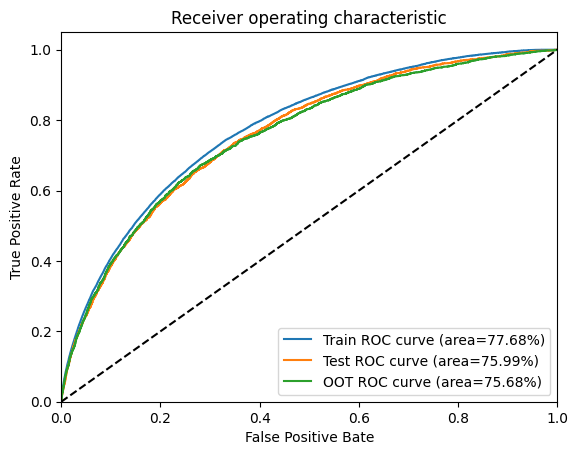

In [ ]:
ROC_curve_combined(y_train,AdaBase_proba_train[:,1],y_test,AdaBase_proba_test[:,1],y_oot,AdaBase_proba_oot[:,1])

### Confusion Matrix

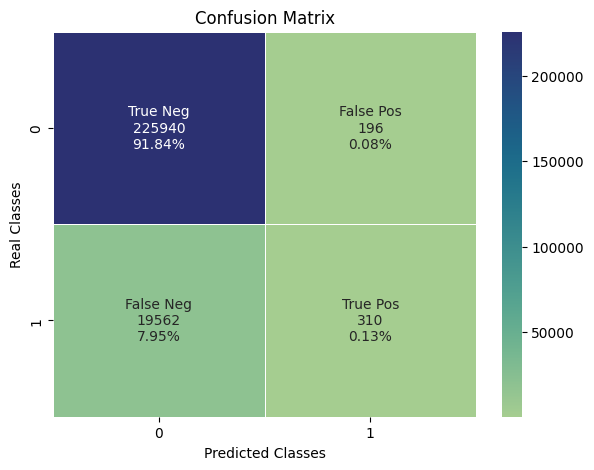

----------------Classification Report----------------
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    226136
           1       0.61      0.02      0.03     19872

    accuracy                           0.92    246008
   macro avg       0.77      0.51      0.49    246008
weighted avg       0.90      0.92      0.88    246008


 ----------------Accuracy, precision, recall, f1_score----------------
Accuracy=0.91969
Precision=0.61265
Recall=0.01560
F1 Score=0.03042


In [ ]:
# Lets plot the confusion matrix
PlotConfusionMatrix(y_train,AdaBase_predict_train)

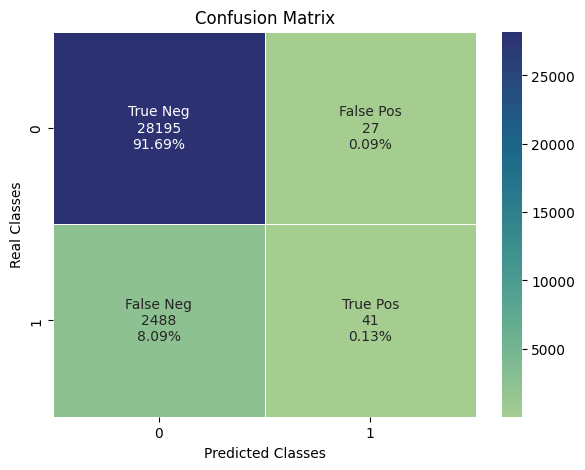

----------------Classification Report----------------
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     28222
           1       0.60      0.02      0.03      2529

    accuracy                           0.92     30751
   macro avg       0.76      0.51      0.49     30751
weighted avg       0.89      0.92      0.88     30751


 ----------------Accuracy, precision, recall, f1_score----------------
Accuracy=0.91821
Precision=0.60294
Recall=0.01621
F1 Score=0.03157


In [ ]:
# Lets plot the confusion matrix
PlotConfusionMatrix(y_test,AdaBase_predict_test)

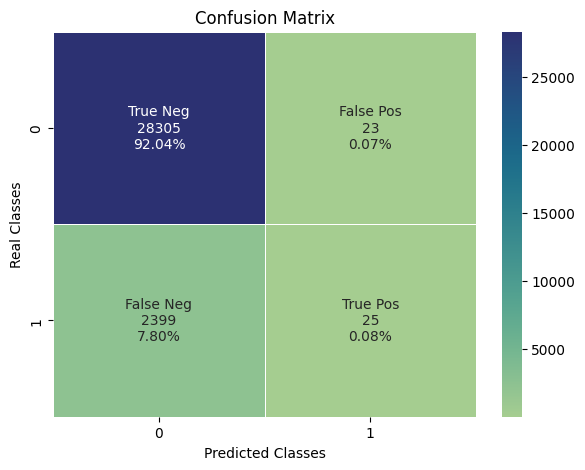

----------------Classification Report----------------
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     28328
           1       0.52      0.01      0.02      2424

    accuracy                           0.92     30752
   macro avg       0.72      0.50      0.49     30752
weighted avg       0.89      0.92      0.88     30752


 ----------------Accuracy, precision, recall, f1_score----------------
Accuracy=0.92124
Precision=0.52083
Recall=0.01031
F1 Score=0.02023


In [ ]:
# Lets plot the confusion matrix
PlotConfusionMatrix(y_oot,AdaBase_predict_oot)

### Decile Table

In [ ]:
decile_tablel(y_train,AdaBase_proba_train[:,1],round_decimal=10,change_deciles=10)

,decile,prob_min,prob_max,ttl_customers,bad_customers,gd_customers,cum gd_customers,cum_bad_customers,KS,Lift,FP,cum FP,default_captr%
0,1,0.480644,0.515839,24601.0,6983.0,17618.0,17618.0,6983.0,27.349008,3.513961,2.52,2.52,35.14
1,2,0.474851,0.480644,24601.0,3792.0,20809.0,38427.0,10775.0,37.229149,2.711079,5.49,10.13,54.22
2,3,0.470700,0.474851,24601.0,2633.0,21968.0,60395.0,13408.0,40.764440,2.249042,8.34,22.94,67.47
3,4,0.467149,0.470700,24601.0,1924.0,22677.0,83072.0,15332.0,40.418368,1.928829,11.79,43.18,77.15
4,5,0.463887,0.467149,24600.0,1455.0,23145.0,106217.0,16787.0,37.505237,1.689513,15.91,73.00,84.48
5,6,0.460626,0.463887,24601.0,1081.0,23520.0,129737.0,17868.0,32.544231,1.498589,21.76,120.02,89.92
6,7,0.457248,0.460626,24601.0,861.0,23740.0,153477.0,18729.0,26.378853,1.346400,27.57,178.25,94.25
7,8,0.453349,0.457247,24601.0,632.0,23969.0,177446.0,19361.0,18.959834,1.217853,37.93,280.77,97.43
8,9,0.447999,0.453349,24601.0,369.0,24232.0,201678.0,19730.0,10.101042,1.103167,65.67,546.55,99.29
9,10,0.372688,0.447999,24600.0,142.0,24458.0,226136.0,19872.0,0.000000,1.000000,172.24,1592.51,100.00


In [ ]:
decile_tablel(y_test,AdaBase_proba_test[:,1],round_decimal=10,change_deciles=10)

,decile,prob_min,prob_max,ttl_customers,bad_customers,gd_customers,cum gd_customers,cum_bad_customers,KS,Lift,FP,cum FP,default_captr%
0,1,0.480849,0.508780,3076.0,833.0,2243.0,2243.0,833.0,24.990220,3.292828,2.69,2.69,32.94
1,2,0.474983,0.480848,3075.0,474.0,2601.0,4844.0,1307.0,34.516591,2.583689,5.49,10.22,51.68
2,3,0.470812,0.474980,3075.0,341.0,2734.0,7578.0,1648.0,38.312704,2.171972,8.02,22.22,65.16
3,4,0.467203,0.470809,3075.0,246.0,2829.0,10407.0,1894.0,38.015774,1.872190,11.50,42.30,74.89
4,5,0.463883,0.467202,3075.0,206.0,2869.0,13276.0,2100.0,35.995458,1.660681,13.93,64.45,83.04
5,6,0.460653,0.463881,3075.0,142.0,2933.0,16209.0,2242.0,31.217724,1.477495,20.65,114.15,88.65
6,7,0.457240,0.460651,3075.0,119.0,2956.0,19165.0,2361.0,25.449043,1.333654,24.84,161.05,93.36
7,8,0.453332,0.457240,3075.0,74.0,3001.0,22166.0,2435.0,17.741553,1.203529,40.55,299.54,96.28
8,9,0.447949,0.453331,3075.0,54.0,3021.0,25187.0,2489.0,9.172369,1.093533,55.94,466.43,98.42
9,10,0.381547,0.447945,3075.0,40.0,3035.0,28222.0,2529.0,0.000000,1.000000,75.88,705.55,100.00


In [ ]:
decile_tablel(y_oot,AdaBase_proba_oot[:,1],round_decimal=10,change_deciles=10)

,decile,prob_min,prob_max,ttl_customers,bad_customers,gd_customers,cum gd_customers,cum_bad_customers,KS,Lift,FP,cum FP,default_captr%
0,1,0.480528,0.508499,3076.0,820.0,2256.0,2256.0,820.0,25.864531,3.381958,2.75,2.75,33.83
1,2,0.474912,0.480526,3075.0,453.0,2622.0,4878.0,1273.0,35.296790,2.625569,5.79,10.77,52.52
2,3,0.470716,0.474909,3075.0,319.0,2756.0,7634.0,1592.0,38.727966,2.189124,8.64,23.93,65.68
3,4,0.467185,0.470715,3075.0,219.0,2856.0,10490.0,1811.0,37.680721,1.867750,13.04,47.90,74.71
4,5,0.463973,0.467183,3075.0,162.0,2913.0,13403.0,1973.0,34.080777,1.627888,17.98,82.73,81.39
5,6,0.460649,0.463969,3076.0,153.0,2923.0,16326.0,2126.0,30.074246,1.461708,19.10,106.71,87.71
6,7,0.457227,0.460649,3075.0,118.0,2957.0,19283.0,2244.0,24.503797,1.322453,25.06,163.42,92.57
7,8,0.453286,0.457225,3075.0,69.0,3006.0,22289.0,2313.0,16.738923,1.192741,43.57,323.03,95.42
8,9,0.447634,0.453286,3075.0,67.0,3008.0,25297.0,2380.0,8.884480,1.090935,44.90,377.57,98.18
9,10,0.384130,0.447632,3075.0,44.0,3031.0,28328.0,2424.0,0.000000,1.000000,68.89,643.82,100.00


### Feature importance:

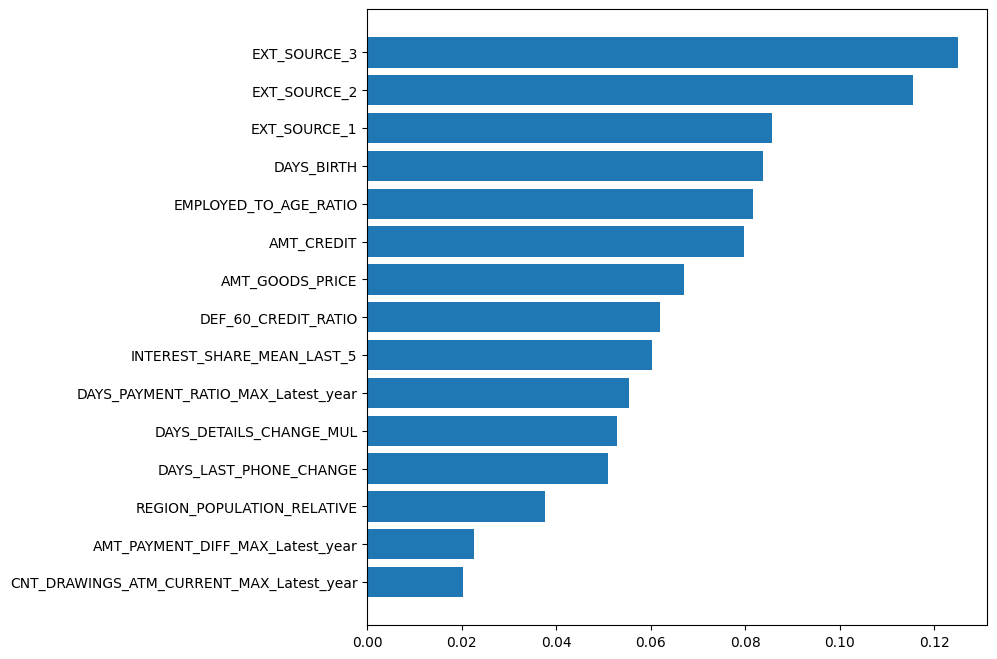

In [ ]:
# model feature importance
plt.figure(figsize=(8,8))

sorted_idx=AdaBase.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx],AdaBase.feature_importances_[sorted_idx])
plt.show()

### Observations and Conclusion:
1. ROC AUC of 75.6% is achieved on the OOT data.
2. At 20% of the total transactions this model was able to capture around 52.52% of total defaulters.

## Predictions on the Kaggle Test dataset:

In [ ]:
# Merged Application test dataframe
pickle_in=open(pickle_path+"application_test_merged.pickle","rb")
application_test_merged=pickle.load(pickle_in)
pickle_in.close()
print("Shape of featurized Application test merged dataframe is",application_test_merged.shape)

Shape of featurized Application test merged dataframe is (48744, 1771)


In [ ]:
# Prediction on the application_test_merged dataframe
AdaBase_proba_test_oot=AdaBase.predict_proba(X_test_oot)

In [ ]:
# Preparing the dataframe to be submitted at Kaggle Submission
AdaBasesol_kaggle=pd.DataFrame(application_test_merged['SK_ID_CURR'])
AdaBasesol_kaggle['TARGET'] = pd.Series(AdaBase_proba_test_oot[:,1])
AdaBasesol_kaggle

,SK_ID_CURR,TARGET
0,100001,0.457779
1,100005,0.466669
2,100013,0.459236
3,100028,0.458761
4,100038,0.480161
...,...,...
48739,456221,0.454559
48740,456222,0.470047
48741,456223,0.457919
48742,456224,0.462906


In [ ]:
# Lets save a dataframe as csv and upload the results on the kaggle submission
AdaBasesol_kaggle.to_csv('/content/drive/MyDrive/Career/DS/Case Studies/Home Credit Default Risk/AdaBasesol_kaggle.csv',index=False)

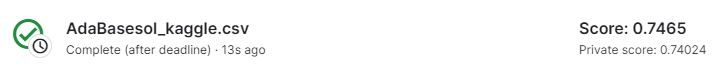

In [ ]:
Image(filename='/content/drive/MyDrive/Career/DS/Case Studies/Home Credit Default Risk/AdaboostKaggleResult.JPG',width=800,height=100)

### Observations about the kaggle solution submission:
ROC AUC of 74.65% is achieved on the kaggle test data for this model.